In [15]:
import csv
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as pl

from sklearn.preprocessing import MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

plt.style.use('bmh')
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [7]:
data = pd.read_csv('./data/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


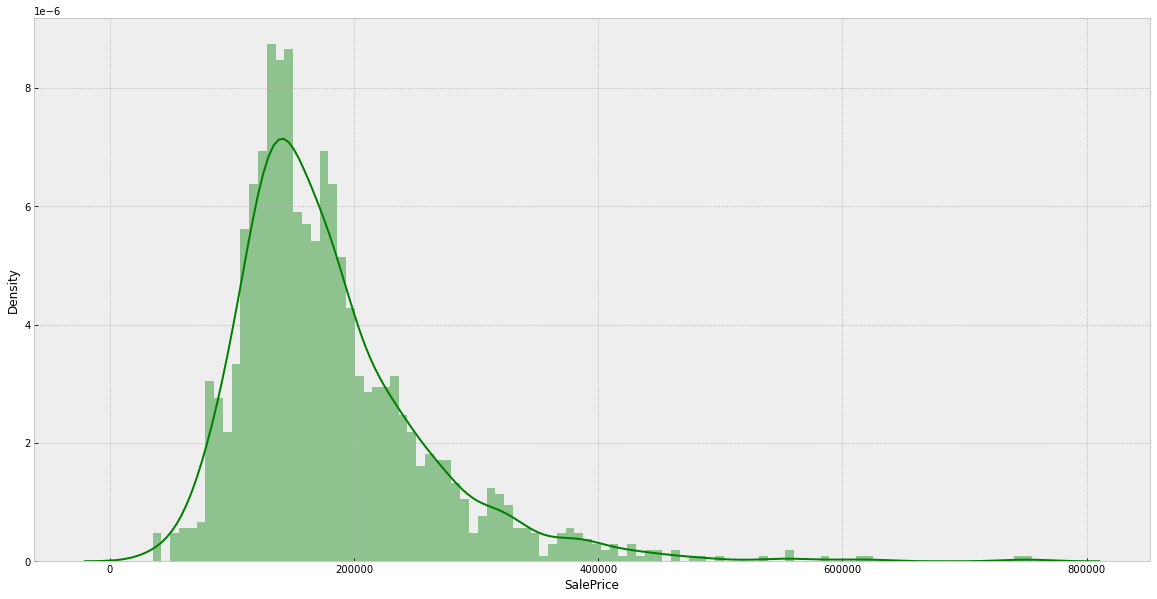

In [9]:
plt.figure(figsize=(20, 10))
sns.distplot(data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [10]:
X = data.drop(['SalePrice'],1)
y = data['SalePrice']
num_cols = [x for x in X if data[x].dtype in ['float64','int64']]
obj_cols = [x for x in X if data[x].dtype == 'object']

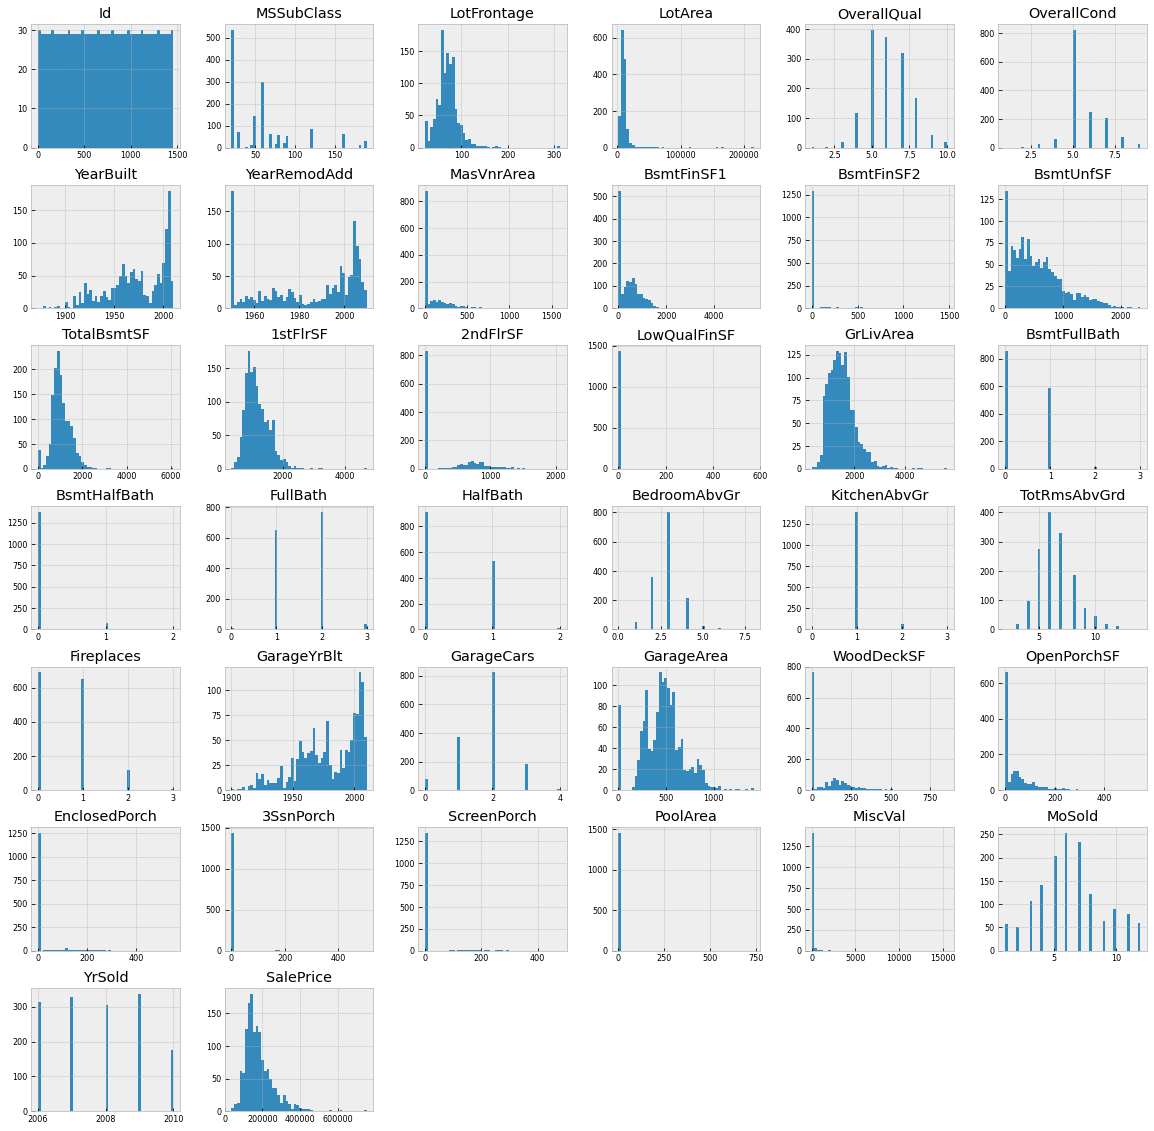

In [11]:
num_data = data.select_dtypes(include = ['float64', 'int64'])
num_data.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

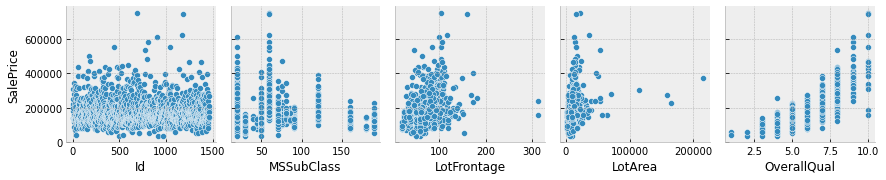

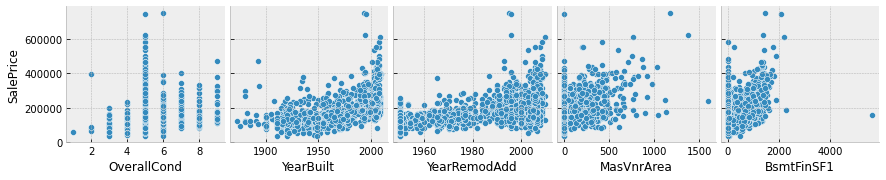

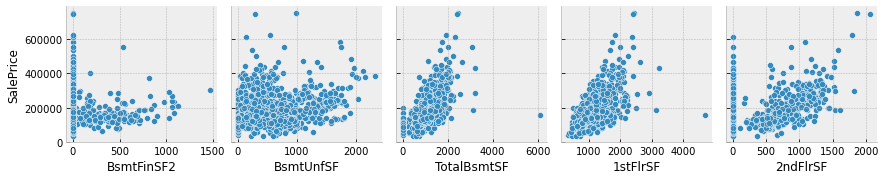

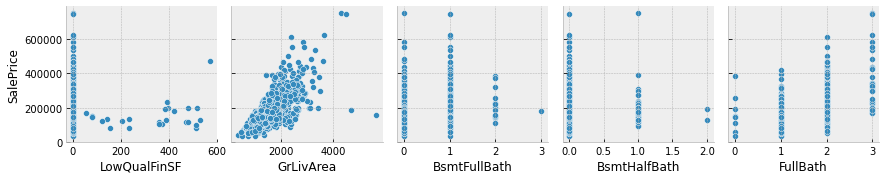

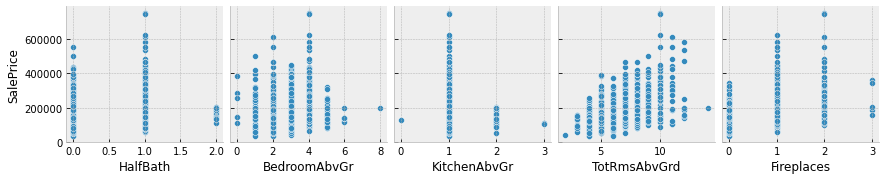

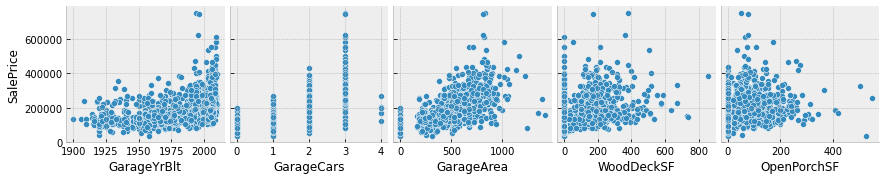

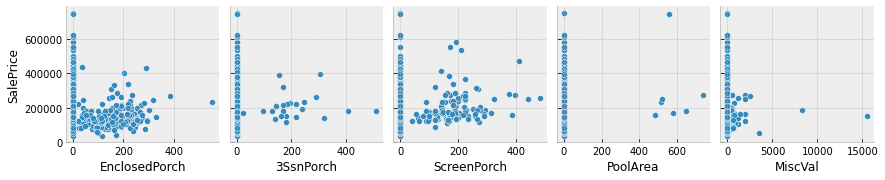

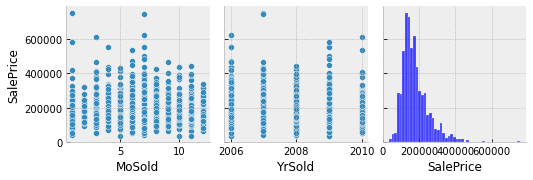

In [12]:
for i in range(0, len(num_data.columns), 5):
    sns.pairplot(data=num_data,
                x_vars=num_data.columns[i:i+5],
                y_vars=['SalePrice'])

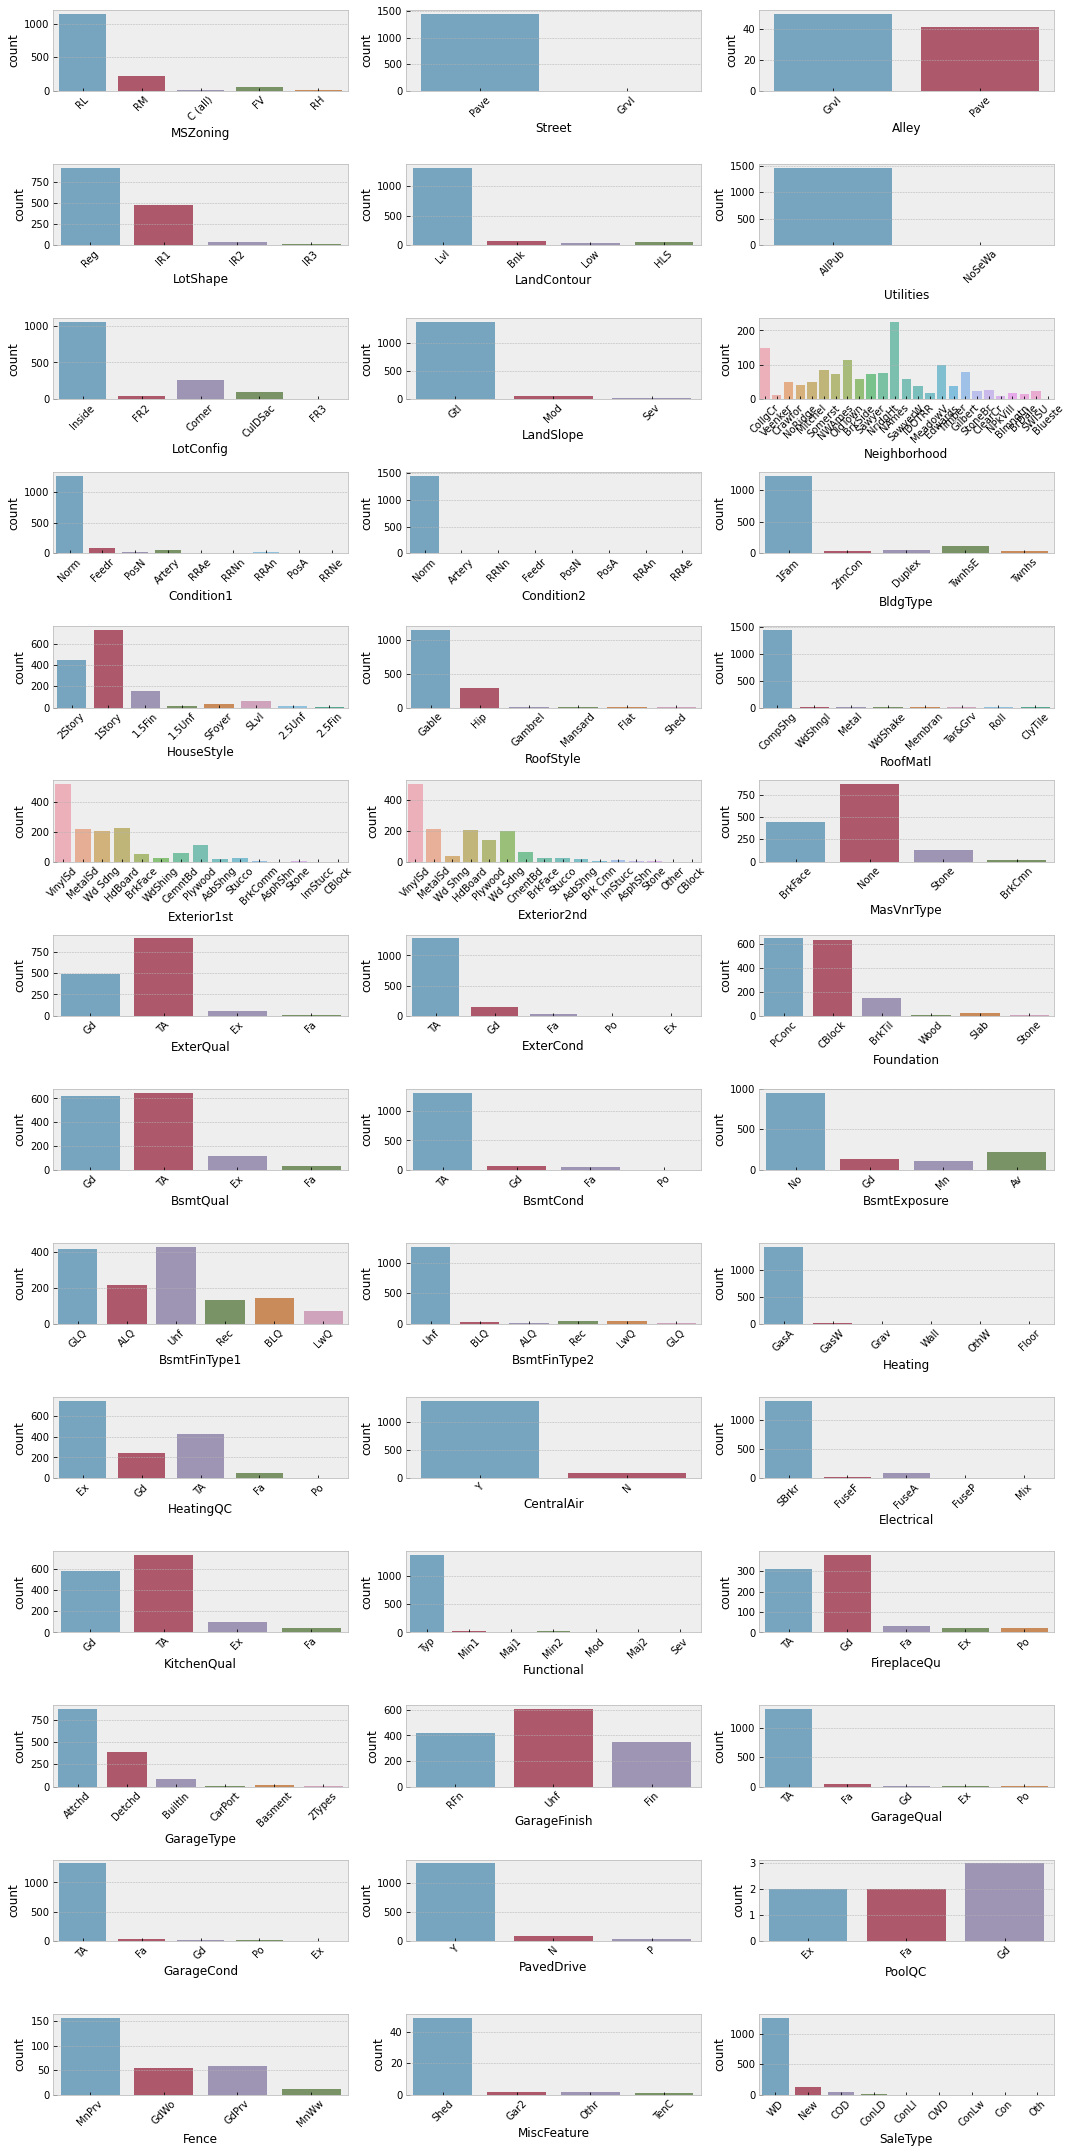

In [13]:
data_obj = data.select_dtypes(include = ['object'])
fig, axes = plt.subplots(round(len(data_obj.columns) / 3), 3, figsize=(15, 30))

for i, ax in enumerate(fig.axes):
    if i < len(data_obj.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=data_obj.columns[i], alpha=0.7, data=data_obj, ax=ax)

fig.tight_layout()

In [14]:
num_pipe = Pipeline(steps = [('impute', SimpleImputer(strategy='mean'))])
obj_pipe = Pipeline(steps = [('impute', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder())])
preprocess = ColumnTransformer([
    ('number', num_pipe, num_cols),
    ('object', obj_pipe, obj_cols)
])
X = preprocess.fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train = X_train.toarray()
X_test = X_test.toarray()
y_train = y_train.values
y_test = y_test.values

X_train.shape, y_train.shape

((1168, 289), (1168,))

In [17]:
class LR(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output):
        super(LR, self).__init__()
        
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, output)
#         self.linear4 = nn.Linear(hidden_size3, output)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = F.dropout(y_pred, p = 0.2)
        
#         y_pred = F.relu(self.linear2(y_pred))
#         y_pred = F.dropout(y_pred, p = 0.3)
        
#         y_pred = F.relu(self.linear3(y_pred))
#         y_pred = F.dropout(y_pred, p = 0.3)
        
        y_pred = F.relu(self.linear2(y_pred))
        y_pred = F.dropout(y_pred, p = 0.2)
        
        y_pred = self.linear3(y_pred)
        
        return y_pred

In [18]:
batch = 100
epochs = 500
acc = 0.0
len_str =0.0
input_size = X_train.shape[1]

# 68 24 24
hidden_size1 = 64
hidden_size2 = 256
hidden_size3 = 512


output = 1
learning_rate = 0.001
loss_list = []
acc_list = []

In [19]:
def create_batch(X, y, batch_size):
    n_samples = len(X)
    np.random.seed(42)
    pos = np.random.permutation(len(X))
    for i in range(0, n_samples, batch_size):
        ind = pos[i:i+batch_size]
        yield (X[ind],y[ind])
        
model = LR(input_size, hidden_size1,  hidden_size2, hidden_size3,output)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.001)

In [20]:
def r2_score(y_pred, y_true):
    mean_y = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_y)**2)
    ss_res = torch.sum((y_true - y_pred)**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [21]:
for epoch in range(epochs):
    for i,(x, y) in enumerate(create_batch(X_train,y_train, batch)):
        inputs = Variable(torch.from_numpy(x)).float() #require float from last layer
        outputs = Variable(torch.from_numpy(y)).float() 
        
        # Forward pass
        pred = model(inputs)
        loss = torch.sqrt(criterion(pred, outputs))
        
        # BW
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if  (epoch+1) % 500 ==0:
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(X_train)//batch}]')

            
            print(f'r2: \n',r2_score(pred,outputs))

Epoch [500/500], Step [1/11]
r2: 
 tensor(-104.2030, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [2/11]
r2: 
 tensor(-102.4186, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [3/11]
r2: 
 tensor(-102.0892, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [4/11]
r2: 
 tensor(-103.0835, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [5/11]
r2: 
 tensor(-102.6463, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [6/11]
r2: 
 tensor(-101.5853, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [7/11]
r2: 
 tensor(-105.7571, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [8/11]
r2: 
 tensor(-102.7845, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [9/11]
r2: 
 tensor(-103.0240, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [10/11]
r2: 
 tensor(-104.3093, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [11/11]
r2: 
 tensor(-101.7768, grad_fn=<RsubBackward1>)
Epoch [500/500], Step [12/11]
r2: 
 tensor(-74.9509, grad_fn=<RsubBackward1>)


In [22]:
data = pd.read_csv('./data/train.csv')

X_test_origin = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")
X_test_processed = preprocess.transform(X_test_origin)
X_test_processed = X_test_processed.toarray()
X_test_var = Variable(torch.FloatTensor(X_test_processed))
with torch.no_grad():
    test_result = Variable(model(X_test_var)).double()
price = test_result.data.numpy()
X_test_1 = pd.read_csv("./data/test.csv")

In [23]:
submission = [['Id', 'SalePrice']]
for i in range(len(price)):
    submission.append([X_test_1.Id.loc[i], price[i][0]])
    
with open('./output/submission.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)
    
print('############################## Complete the competition ##############################')

############################## Complete the competition ##############################
